# Google Trends Data Preprocessing

#### Reference: Djorno, Santillana, Yang, Restoring the Forecasting Power of Google Trends with Statistical Preprocessing. 9 Apr 2025. ArXiv:2504.07032v1 [stat.AP]

- Aggregation via Clustering
- Denoising (skipped since multiple downloads were not done)
- Detrending

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sml
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import datetime
import shap
from pmdarima import auto_arima

/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
# Convert string to datetime and then format
def format_date(date_str):
    date_obj = datetime.datetime.strptime(date_str, '%Y-%m')
    return date_obj.strftime('%b \'%y')

In [5]:
# get rescaled trends dataset
full_trends_data = pd.read_csv('./rescaled_combined_trends_data_2011_2025.csv')
# Apply to your dataframe's Month column
full_trends_data['Month'] = full_trends_data['Month'].apply(format_date)
full_trends_data.tail()

,Month,Leisure,Liquid,Rent,Price,Kerosene heater,Public health,Mixture,Gas cylinder,Filling station,...,Cost of living,Samsung,cheap,Health insurance,Tuition payments,Shoes,Budget,Mental health,Soup,Emergency telephone number
166,Nov '24,29.0,72.0,75.0,96.0,0.0,50.0,72.0,68.6,68.0,...,52.0,94.6,46.0,9.0,90.0,65.0,24.9,59.0,70.0,51.0
167,Dec '24,15.0,58.0,75.0,93.0,0.0,41.0,49.0,63.0,72.0,...,44.0,99.8,48.0,8.0,74.5,71.0,27.8,48.0,56.0,50.0
168,Jan '25,31.0,74.0,84.0,91.0,36.0,52.0,71.0,112.5,76.0,...,54.0,104.0,49.0,9.0,111.1,58.0,26.8,57.0,58.0,62.0
169,Feb '25,27.0,76.0,78.0,93.0,37.0,56.0,71.0,77.6,81.0,...,58.0,92.5,56.0,8.0,93.4,60.0,26.8,59.0,59.0,63.0
170,Mar '25,22.0,91.0,82.0,93.0,0.0,46.0,68.0,76.5,86.0,...,60.0,101.9,54.0,9.0,64.5,63.0,24.9,55.0,59.0,59.0


# Aggregation
Combining keywords with similar semantic meanings (via correlation) and addressing missing values (zeros) due to Google privacy threshold and sampling variability in less popular keywords.

Clusters: 1, WCSS: 19656.00
Clusters: 2, WCSS: 15345.66
Clusters: 3, WCSS: 11938.11
Clusters: 4, WCSS: 9806.50
Clusters: 5, WCSS: 8708.86
Clusters: 6, WCSS: 7814.35
Clusters: 7, WCSS: 7174.64
Clusters: 8, WCSS: 6837.31
Clusters: 9, WCSS: 6509.04
Clusters: 10, WCSS: 6182.05
Clusters: 11, WCSS: 5871.47
Clusters: 12, WCSS: 5625.07
Clusters: 13, WCSS: 5414.71
Clusters: 14, WCSS: 5240.91
Clusters: 15, WCSS: 5077.81
Clusters: 16, WCSS: 4916.98
Clusters: 17, WCSS: 4771.42
Clusters: 18, WCSS: 4640.22
Clusters: 19, WCSS: 4526.46
Clusters: 20, WCSS: 4417.54
Clusters: 21, WCSS: 4313.75
Clusters: 22, WCSS: 4212.47
Clusters: 23, WCSS: 4119.61
Clusters: 24, WCSS: 4029.28
Clusters: 25, WCSS: 3940.69
Clusters: 26, WCSS: 3852.31
Clusters: 27, WCSS: 3765.80
Clusters: 28, WCSS: 3682.95
Clusters: 29, WCSS: 3602.75
Clusters: 30, WCSS: 3525.45
Clusters: 31, WCSS: 3449.00
Clusters: 32, WCSS: 3372.74
Clusters: 33, WCSS: 3298.93
Clusters: 34, WCSS: 3227.75
Clusters: 35, WCSS: 3159.68
Clusters: 36, WCSS: 3094.4

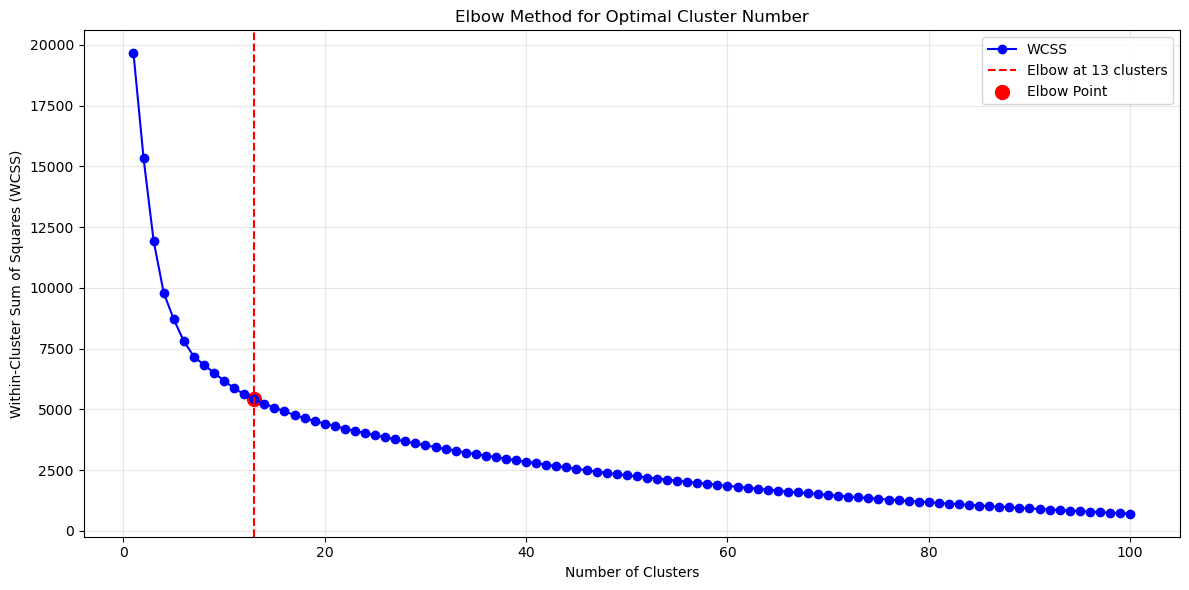

The optimal number of clusters is: 13


In [6]:
# Get optimal number of clusters using elbow method

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

def calculate_wcss(data, n_clusters):
    # Perform hierarchical clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    clustering.fit(data)
    
    # Calculate WCSS
    wcss = 0
    for i in range(n_clusters):
        cluster_points = data[clustering.labels_ == i]
        cluster_center = np.mean(cluster_points, axis=0)
        wcss += np.sum((cluster_points - cluster_center) ** 2)
    return wcss

# Prepare data for clustering
# Drop the 'Month' column and convert to numpy array and exclude the test set
# X = full_trends_data.drop('Month', axis=1)
X = full_trends_data.drop('Month', axis=1).iloc[:-15]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate WCSS for different numbers of clusters
max_clusters = 100
wcss_values = []
n_clusters_range = range(1, max_clusters + 1)

for n_clusters in n_clusters_range:
    wcss = calculate_wcss(X_scaled, n_clusters)
    wcss_values.append(wcss)

# # Plot the elbow curve
# plt.figure(figsize=(10, 6))
# plt.plot(n_clusters_range, wcss_values, 'bo-')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
# plt.title('Elbow Method for Optimal Cluster Number')
# plt.grid(True)
# plt.show()

# Print WCSS values for each number of clusters
for n_clusters, wcss in zip(n_clusters_range, wcss_values):
    print(f'Clusters: {n_clusters}, WCSS: {wcss:.2f}')


from kneed import KneeLocator

# Find the elbow using the knee detector
kl = KneeLocator(
    list(n_clusters_range),  # x values
    wcss_values,            # y values
    curve='convex',         # curve is convex
    direction='decreasing'  # values are decreasing
)

# Plot with the elbow point highlighted
plt.figure(figsize=(12, 6))
plt.plot(n_clusters_range, wcss_values, 'bo-', label='WCSS')
plt.axvline(x=kl.elbow, color='r', linestyle='--', label=f'Elbow at {kl.elbow} clusters')
plt.scatter(kl.elbow, kl.elbow_y, c='red', s=100, label='Elbow Point')

plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Cluster Number')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("elbow_plot.png")
plt.show()

print(f"The optimal number of clusters is: {kl.elbow}")

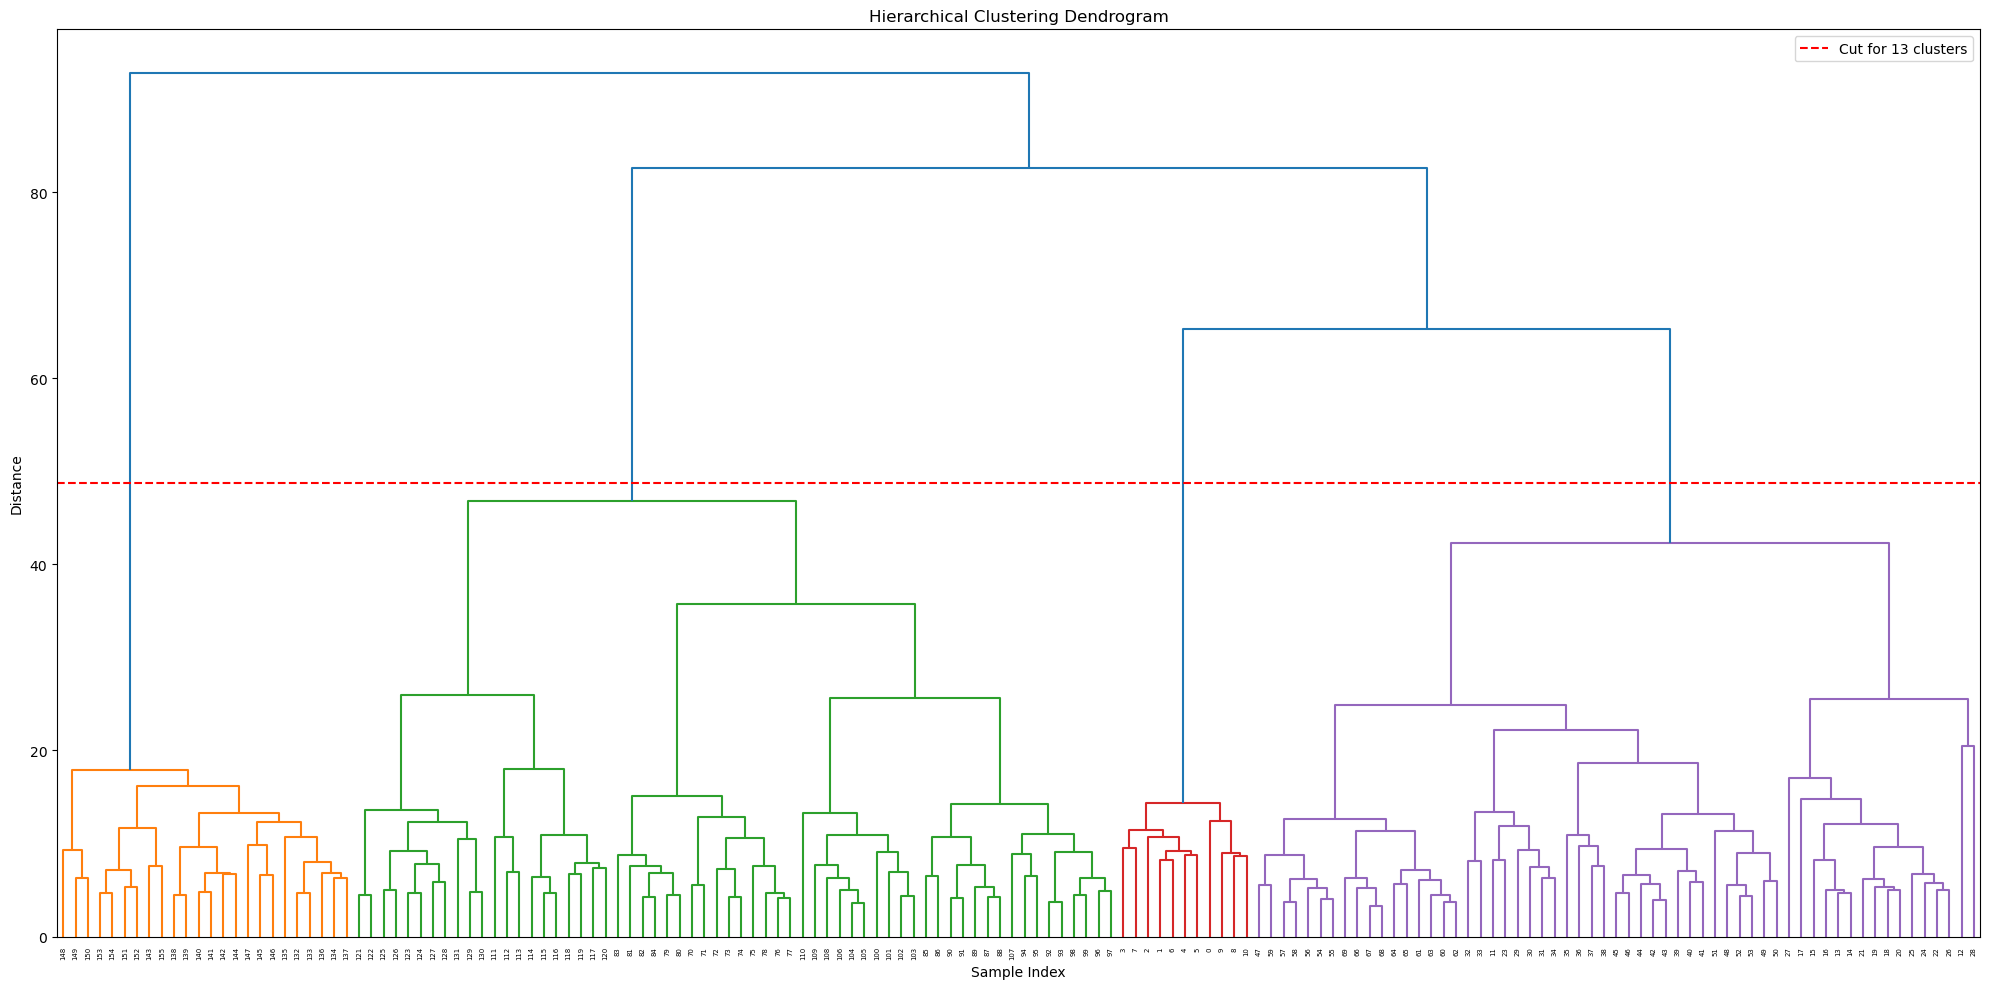

,Cluster,Keyword
0,0,"[State of emergency, Gasoline, Emergency, Fuel]"
1,1,"[Rent, Lagos, Flight, Fare, Credit, Pump, Inve..."
2,2,"[Globacom Limited, Wealth, Dance, China, Sport..."
3,3,"[Liquid, Price, Kerosene heater, Mixture, Gas ..."
4,4,"[Nigerian cuisine, Hyperinflation, Stove, Food..."
5,5,"[Public health, Made In China, Emergency manag..."
6,6,"[Emirates Telecom, Deflation, Immigration, Sam..."
7,7,"[Bharti Airtel, Clothing, Fried rice, Data, In..."
8,8,"[Gas, Recreation, Cost, Health, Health educati..."
9,9,"[Leisure, Petroleum industry, Goods]"


|    |   Cluster | Keyword                                                                                                                                                                                                                                                                                                                                                                                                  |
|---:|----------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 |         0 | ['State of emergency', 'Gasoline', 'Emergency', 'Fuel']                                                                                                  

In [7]:
# Do hierachical clustering based on optimal cluster count

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Perform hierarchical clustering on keywords (features)
n_clusters = 13
X_scaled_transposed = X_scaled.T  # Transpose the data to cluster keywords
clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering.fit(X_scaled_transposed)

# Create linkage matrix for dendrogram
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram')

# Plot the dendrogram
dendrogram(linkage_matrix)

# Customize the plot
plt.xlabel('Sample Index')
plt.ylabel('Distance')

# Add a horizontal line to show the cut for n_clusters
plt.axhline(y=plt.ylim()[1]/2, color='r', linestyle='--', 
            label=f'Cut for {n_clusters} clusters')

plt.legend()
plt.tight_layout()
plt.savefig("dendrogram.png")
plt.show()

# Create a DataFrame with cluster assignments
cluster_df = pd.DataFrame({
    'Keyword': X.columns,
    'Cluster': clustering.labels_
})

# Group keywords by cluster
cluster_groups = cluster_df.groupby('Cluster')['Keyword'].agg(list).reset_index()
display(cluster_groups)
print(cluster_groups.to_markdown())
cluster_groups['Size'] = cluster_groups['Keyword'].str.len()

# Sort by cluster number and display results
cluster_groups = cluster_groups.sort_values('Cluster')
print("Cluster Summary:")
print("-" * 50)
for _, row in cluster_groups.iterrows():
    print(f"\nCluster {row['Cluster']} ({row['Size']} keywords):")
    print(", ".join(row['Keyword']))


In [8]:
# skip getting the keywords again using the boolean operator '+'
# just add the values them up 

# Create a new DataFrame with just the Month column
aggregated_trends = pd.DataFrame({'Month': full_trends_data['Month']})

# For each cluster, sum up the values of all keywords in that cluster
for cluster_idx in cluster_groups['Cluster']:
    # Get keywords for this cluster
    cluster_keywords = cluster_groups[cluster_groups['Cluster'] == cluster_idx]['Keyword'].iloc[0]
    
    # Sum up values for all keywords in this cluster
    cluster_values = full_trends_data[cluster_keywords].sum(axis=1)
    
    # Add to new DataFrame with cluster name
    aggregated_trends[f'cluster_{cluster_idx}'] = cluster_values

# Display the first few rows of the aggregated data
display(aggregated_trends)

# Print shape to confirm
print(f"Original shape: {full_trends_data.shape}")
print(f"Aggregated shape: {aggregated_trends.shape}")

,Month,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12
0,Jan '11,58.0,984.2,189.0,907.9,119.0,1813.0,80.7,154.0,479.0,88.0,705.4,53.0,82.9
1,Feb '11,56.0,953.6,180.0,956.9,202.0,1971.6,83.6,155.0,533.0,138.0,680.1,53.0,86.9
2,Mar '11,58.0,965.6,229.0,956.9,169.0,2112.5,154.3,145.0,505.0,133.0,655.3,89.0,103.0
3,Apr '11,57.0,935.8,187.0,962.9,190.0,1846.8,96.4,159.0,476.0,104.0,616.9,57.0,105.1
4,May '11,57.0,927.1,194.0,927.9,246.0,2029.8,109.1,145.0,538.0,119.0,634.6,53.0,106.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,Nov '24,55.0,716.4,149.0,2008.5,386.0,743.0,64.0,273.0,438.0,102.0,457.9,96.0,212.6
167,Dec '24,53.0,718.3,141.0,1865.9,342.0,604.4,64.0,293.0,357.0,68.0,396.8,101.0,203.8
168,Jan '25,61.0,763.2,139.0,2106.4,397.0,800.0,72.0,260.0,454.0,98.0,463.8,102.0,214.0
169,Feb '25,59.0,699.4,158.0,2058.5,371.0,823.4,71.0,292.0,473.0,97.0,508.8,89.0,217.5


Original shape: (171, 127)
Aggregated shape: (171, 14)


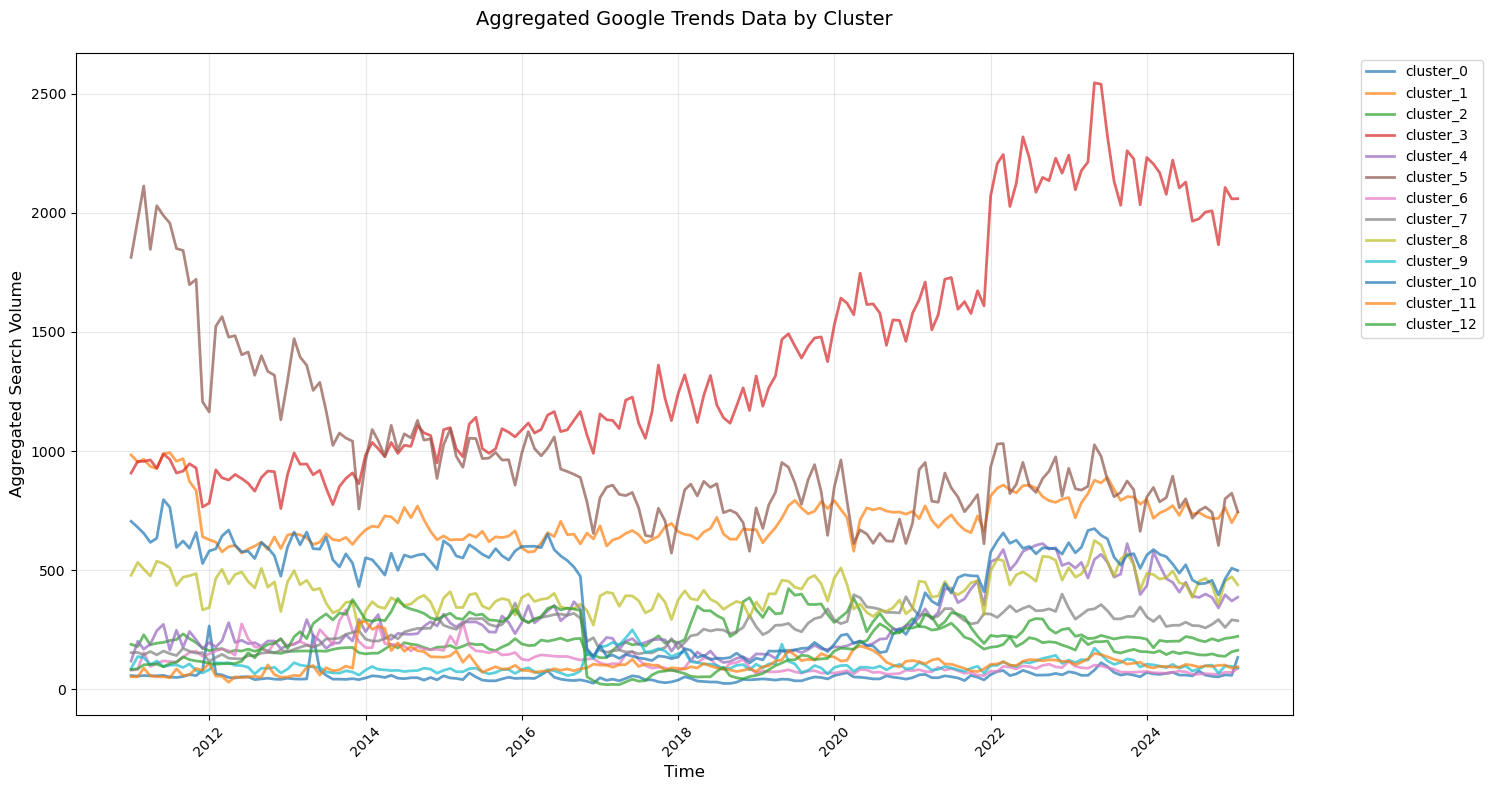

In [9]:
# Convert Month to datetime for proper x-axis sorting
aggregated_trends['Month'] = pd.to_datetime(aggregated_trends['Month'], format="%b '%y")

# Create the plot
plt.figure(figsize=(15, 8))

# Plot each cluster
for col in [col for col in aggregated_trends.columns if 'cluster_' in col]:
    plt.plot(aggregated_trends['Month'], 
             aggregated_trends[col], 
             label=col,
             alpha=0.7,
             linewidth=2)

# Customize the plot
plt.title('Aggregated Google Trends Data by Cluster', fontsize=14, pad=20)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Aggregated Search Volume', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

# Detrending

Aggregated Trends DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       171 non-null    datetime64[ns]
 1   cluster_0   171 non-null    float64       
 2   cluster_1   171 non-null    float64       
 3   cluster_2   171 non-null    float64       
 4   cluster_3   171 non-null    float64       
 5   cluster_4   171 non-null    float64       
 6   cluster_5   171 non-null    float64       
 7   cluster_6   171 non-null    float64       
 8   cluster_7   171 non-null    float64       
 9   cluster_8   171 non-null    float64       
 10  cluster_9   171 non-null    float64       
 11  cluster_10  171 non-null    float64       
 12  cluster_11  171 non-null    float64       
 13  cluster_12  171 non-null    float64       
dtypes: datetime64[ns](1), float64(13)
memory usage:

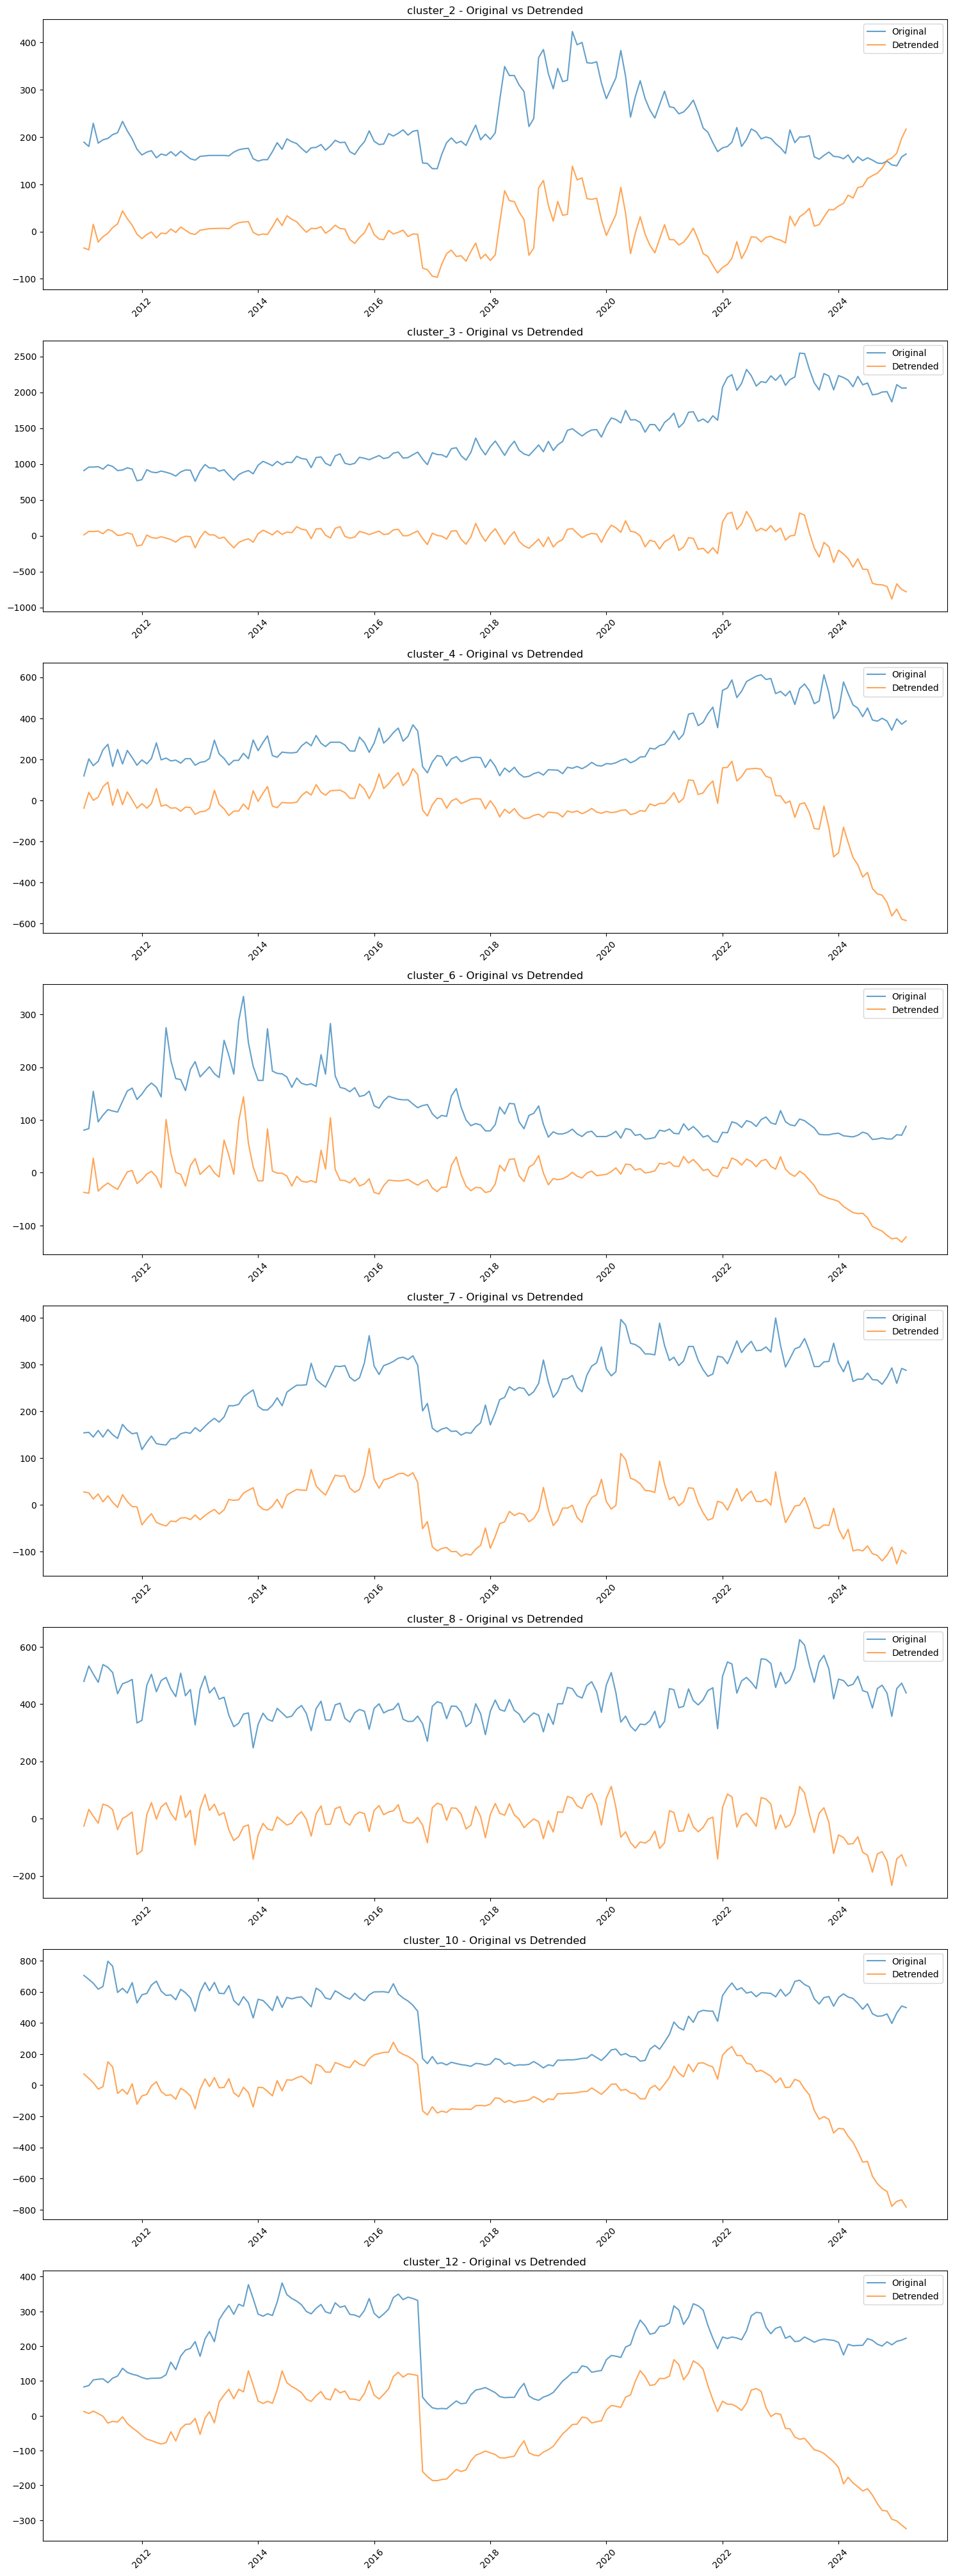


Verifying Stationarity of Detrended Series:
----------------------------------------

Testing cluster_2_detrended:
ADF Statistic: -3.3113
p-value: 0.0144
Critical values:
	1%: -3.4738
	5%: -2.8806
	10%: -2.5769

Testing cluster_3_detrended:
ADF Statistic: -3.9812
p-value: 0.0015
Critical values:
	1%: -3.4769
	5%: -2.8820
	10%: -2.5777

Testing cluster_4_detrended:
ADF Statistic: -2.1925
p-value: 0.2090
Critical values:
	1%: -3.4756
	5%: -2.8814
	10%: -2.5774

Testing cluster_6_detrended:
ADF Statistic: -7.0852
p-value: 0.0000
Critical values:
	1%: -3.4733
	5%: -2.8804
	10%: -2.5768

Testing cluster_7_detrended:
ADF Statistic: -2.6861
p-value: 0.0765
Critical values:
	1%: -3.4773
	5%: -2.8821
	10%: -2.5777

Testing cluster_8_detrended:
ADF Statistic: -4.0963
p-value: 0.0010
Critical values:
	1%: -3.4769
	5%: -2.8820
	10%: -2.5777

Testing cluster_10_detrended:
ADF Statistic: -2.7800
p-value: 0.0612
Critical values:
	1%: -3.4769
	5%: -2.8820
	10%: -2.5777

Testing cluster_12_detrended:


In [10]:
# Get dataframe information
print("Aggregated Trends DataFrame Info:")
print("-" * 40)
aggregated_trends.info()

# Perform ADF test on each cluster column (excluding last 15 rows)
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    return result[1]  # Return p-value

# Dictionary to store which columns need detrending
detrending_needed = {}
train_data = aggregated_trends.iloc[:-15].copy()

print("\nStationarity Tests:")
print("-" * 40)
for col in aggregated_trends.columns:
    if col != 'Month':
        print(f"\nTesting {col}:")
        p_value = adf_test(train_data[col])
        detrending_needed[col] = p_value > 0.05

# Detrend non-stationary series
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

detrended_trends = aggregated_trends.copy()
time_index = np.arange(len(aggregated_trends))
train_index = np.arange(len(train_data))

for col in detrending_needed:
    if detrending_needed[col]:
        print(f"\nDetrending {col}:")
        
        # Try different polynomial degrees
        best_degree = 1
        best_r2 = -np.inf
        
        for degree in range(1, 4):
            # Prepare polynomial features
            poly = PolynomialFeatures(degree=degree)
            X_poly = poly.fit_transform(train_index.reshape(-1, 1))
            
            # Fit model
            model = LinearRegression()
            model.fit(X_poly, train_data[col])
            
            # Calculate R-squared
            r2 = model.score(X_poly, train_data[col])
            print(f"Degree {degree} R-squared: {r2:.4f}")
            
            if r2 > best_r2:
                best_r2 = r2
                best_degree = degree
        
        # Apply best polynomial fit to full dataset
        print(f"Using polynomial degree {best_degree}")
        poly = PolynomialFeatures(degree=best_degree)
        X_poly_full = poly.fit_transform(time_index.reshape(-1, 1))
        
        model = LinearRegression()
        model.fit(poly.fit_transform(train_index.reshape(-1, 1)), train_data[col])
        
        # Remove trend
        trend = model.predict(X_poly_full)
        detrended_trends[f"{col}_detrended"] = detrended_trends[col] - trend

# Plot original vs detrended for non-stationary series
plt.figure(figsize=(15, 5*len(detrending_needed)))
plot_idx = 1

for col in detrending_needed:
    if detrending_needed[col]:
        plt.subplot(len(detrending_needed), 1, plot_idx)
        plt.plot(aggregated_trends['Month'], aggregated_trends[col], 
                 label='Original', alpha=0.7)
        plt.plot(aggregated_trends['Month'], detrended_trends[f"{col}_detrended"], 
                 label='Detrended', alpha=0.7)
        plt.title(f"{col} - Original vs Detrended")
        plt.legend()
        plt.xticks(rotation=45)
        plot_idx += 1

plt.tight_layout()
plt.show()

# Verify stationarity of detrended series
print("\nVerifying Stationarity of Detrended Series:")
print("-" * 40)
for col in detrending_needed:
    if detrending_needed[col]:
        print(f"\nTesting {col}_detrended:")
        _ = adf_test(detrended_trends[f"{col}_detrended"].iloc[:-15])

In [11]:
# # Create figure with two vertical subplots
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# # Plot original aggregated trends (top subplot)
# for col in [col for col in aggregated_trends.columns if 'cluster_' in col]:
#     ax1.plot(aggregated_trends['Month'], 
#              aggregated_trends[col], 
#              label=col,
#              alpha=0.7,
#              linewidth=2)

# # Customize top subplot
# ax1.set_title('Original Aggregated Google Trends Data by Cluster', fontsize=14, pad=20)
# ax1.set_xlabel('Time', fontsize=12)
# ax1.set_ylabel('Aggregated Search Volume', fontsize=12)
# ax1.tick_params(axis='x', rotation=45)
# ax1.grid(True, alpha=0.3)
# ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# # Plot detrended series (bottom subplot)
# for col in [col for col in detrended_trends.columns if 'detrended' in col]:
#     ax2.plot(detrended_trends['Month'], 
#              detrended_trends[col], 
#              label=col,
#              alpha=0.7,
#              linewidth=2)

# # Customize bottom subplot
# ax2.set_title('Detrended Google Trends Data by Cluster', fontsize=14, pad=20)
# ax2.set_xlabel('Time', fontsize=12)
# ax2.set_ylabel('Detrended Search Volume', fontsize=12)
# ax2.tick_params(axis='x', rotation=45)
# ax2.grid(True, alpha=0.3)
# ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# # Adjust layout to prevent overlapping
# plt.tight_layout()
# plt.show()

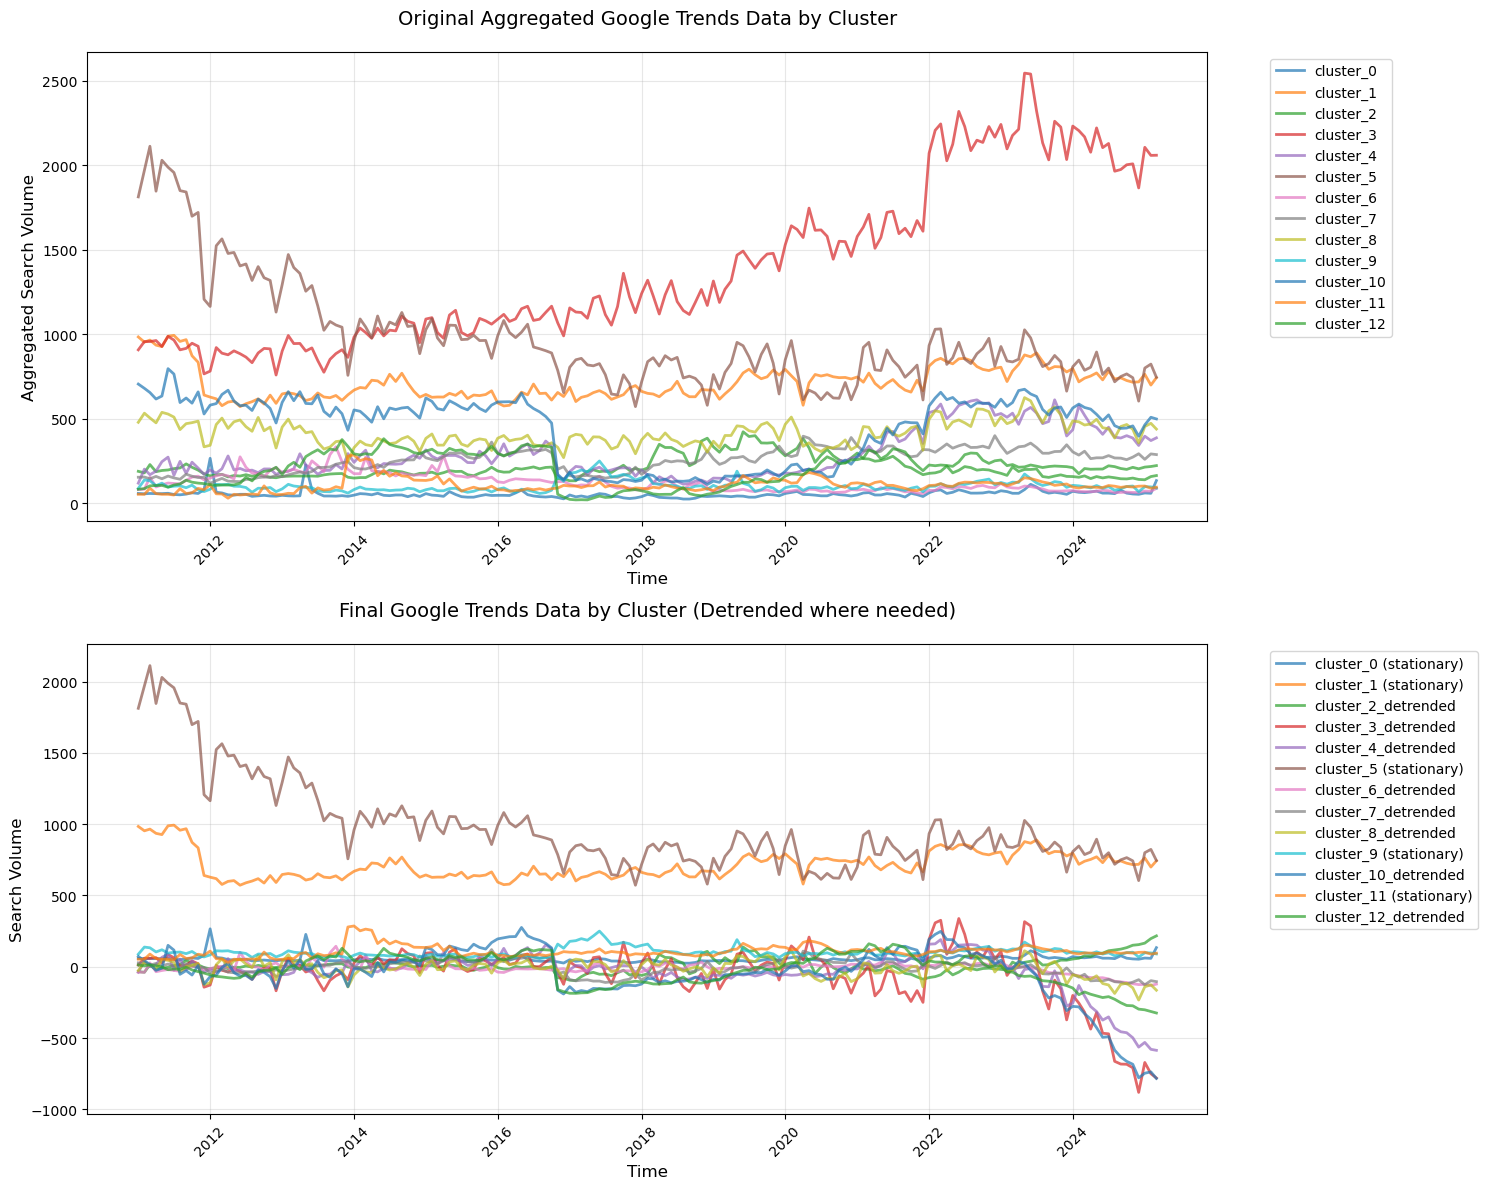

In [12]:
# Create figure with two vertical subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot original aggregated trends (top subplot)
for col in [col for col in aggregated_trends.columns if 'cluster_' in col]:
    ax1.plot(aggregated_trends['Month'], 
             aggregated_trends[col], 
             label=col,
             alpha=0.7,
             linewidth=2)

# Customize top subplot
ax1.set_title('Original Aggregated Google Trends Data by Cluster', fontsize=14, pad=20)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Aggregated Search Volume', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot bottom subplot - include both detrended and non-detrended series
for col in [col for col in aggregated_trends.columns if 'cluster_' in col]:
    if detrending_needed[col]:
        # Plot detrended version for non-stationary series
        ax2.plot(detrended_trends['Month'], 
                 detrended_trends[f"{col}_detrended"], 
                 label=f"{col}_detrended",
                 alpha=0.7,
                 linewidth=2)
    else:
        # Plot original version for already stationary series
        ax2.plot(detrended_trends['Month'], 
                 detrended_trends[col], 
                 label=f"{col} (stationary)",
                 alpha=0.7,
                 linewidth=2)

# Customize bottom subplot
ax2.set_title('Final Google Trends Data by Cluster (Detrended where needed)', fontsize=14, pad=20)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Search Volume', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig("detrending.png")
plt.show()

In [13]:
# Create final DataFrame with Month column and all processed series
final_trends = pd.DataFrame({'Month': aggregated_trends['Month']})

# Add processed series (detrended if needed, original if already stationary)
for col in [col for col in aggregated_trends.columns if 'cluster_' in col]:
    if detrending_needed[col]:
        # Use detrended version
        final_trends[col] = detrended_trends[f"{col}_detrended"]
    else:
        # Use original version
        final_trends[col] = aggregated_trends[col]

# Save to CSV
final_trends.to_csv('detrended_google_trends_data.csv', index=False)
print("Saved processed trends data to 'detrended_google_trends_data.csv'")

Saved processed trends data to 'detrended_google_trends_data.csv'


In [14]:
detrended_trends_df = pd.read_csv('./detrended_google_trends_data.csv')
display(detrended_trends_df)

,Month,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12
0,2011-01-01,58.0,984.2,-34.674853,12.265352,-38.543168,1813.0,-37.247719,27.393146,-26.353890,88.0,71.972304,53.0,12.209687
1,2011-02-01,56.0,953.6,-38.634425,60.135251,38.551132,1971.6,-38.928577,25.214203,32.212519,138.0,43.370200,53.0,6.516475
2,2011-03-01,58.0,965.6,15.189084,58.995884,-0.113440,2112.5,27.362487,12.089573,8.703165,133.0,15.639949,89.0,13.240377
3,2011-04-01,57.0,935.8,-22.201174,63.845241,15.459047,1846.8,-34.776741,23.018628,-15.881686,104.0,-25.325198,57.0,6.277186
4,2011-05-01,57.0,927.1,-10.802047,27.681307,66.264518,2029.8,-26.148478,6.000740,50.458231,119.0,-9.831991,53.0,-1.477304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,2024-11-01,55.0,716.4,150.990991,-708.490871,-498.038005,743.0,-118.844748,-108.091417,-148.082623,102.0,-684.072739,96.0,-273.809202
167,2024-12-01,53.0,718.3,155.187379,-881.323792,-563.679889,604.4,-125.233229,-90.862949,-233.455920,68.0,-779.178754,101.0,-297.274710
168,2025-01-01,61.0,763.2,165.690055,-671.400097,-530.756567,800.0,-123.817629,-126.684515,-140.860896,98.0,-746.933297,102.0,-302.121445
169,2025-02-01,59.0,699.4,197.502170,-750.221800,-579.272110,823.4,-131.600162,-97.556743,-126.297285,97.0,-737.443119,89.0,-314.053616
